In [4]:
import joblib
import uuid
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
data = pd.read_csv("/Users/boitumelomaseko/Data Science/Projects/Credit Card/artifacts/training_dataset.csv")
data.shape

(270566, 31)

In [6]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,84558.0,1.225896,-0.559735,0.748132,-0.899091,-1.176249,-0.359097,-0.824614,0.254095,1.901373,...,-0.006633,0.093979,-0.064239,-0.035617,0.443813,-0.676337,0.075715,0.017241,1.00,0
1,43575.0,-0.316250,0.973117,0.819911,-0.212413,0.603125,0.038185,0.542425,0.192143,-0.163004,...,-0.314296,-0.850765,-0.093547,-1.015952,-0.135989,0.167666,0.253151,0.082388,4.49,0
2,142280.0,2.113127,-0.025811,-1.341639,0.248042,0.242917,-0.805679,0.206122,-0.321813,0.505600,...,-0.328919,-0.780767,0.248977,-0.639701,-0.187189,0.237040,-0.067867,-0.065920,0.89,0
3,55335.0,1.222559,0.262690,0.115831,0.566754,-0.026937,-0.396594,0.005081,-0.038370,0.068277,...,-0.279870,-0.794678,0.108408,-0.328816,0.184750,0.145903,-0.009294,0.024966,9.99,0
4,35963.0,-5.263760,-6.321337,0.071344,0.149963,3.436535,-4.037193,-2.685129,0.671619,-1.287235,...,0.991033,0.468536,0.079092,0.636338,-0.279928,-0.429728,0.352316,-0.810679,108.00,0


In [7]:
data['Class'].value_counts()

Class
0    270099
1       467
Name: count, dtype: int64

In [8]:
round(data.Class.value_counts()/len(data)*100,2)

Class
0    99.83
1     0.17
Name: count, dtype: float64

Note: Highly disproportionate dataset. Models are will try to discount the lesser class and will find it difficult to detect fraudulent cases. This is what I should confront. 

In [9]:
def nulls_summary_table(df):
    """
    Returns a summary table showing null value counts and percentage
    
    Parameters:
    df (DataFrame): Dataframe to check
    
    Returns:
    null_values (DataFrame)
    """
    null_values = pd.DataFrame(df.isnull().sum())
    null_values[1] = null_values[0]/len(df)
    null_values.columns = ['null_count','null_pct']
    return null_values

nulls_summary_table(data)

,null_count,null_pct
Time,0,0.0
V1,0,0.0
V2,0,0.0
V3,0,0.0
V4,0,0.0
V5,0,0.0
V6,0,0.0
V7,0,0.0
V8,0,0.0
V9,0,0.0


No null values on this dataset. 

<Axes: >

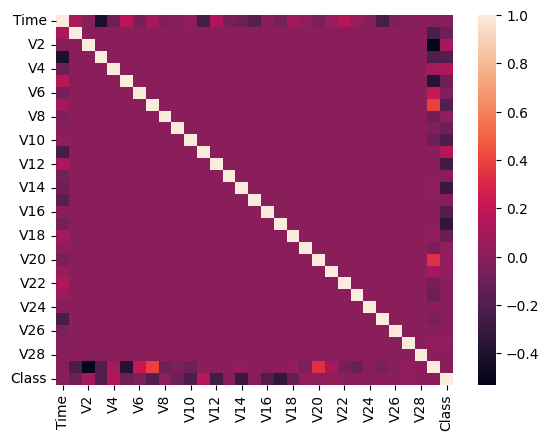

In [10]:
sns.heatmap(data.corr())

In [11]:
df_corr = pd.DataFrame(round(data.corr(),3))

In [12]:
df_corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000,0.117,-0.011,-0.420,-0.106,0.174,-0.063,0.085,-0.036,-0.008,...,0.045,0.144,0.051,-0.016,-0.233,-0.041,-0.005,-0.009,-0.011,-0.012
V1,0.117,1.000,-0.002,0.001,0.000,0.002,-0.001,0.001,0.000,0.001,...,0.000,-0.000,0.001,-0.000,-0.001,-0.000,0.000,-0.004,-0.227,-0.103
V2,-0.011,-0.002,1.000,-0.002,0.001,0.001,-0.001,0.000,0.000,-0.001,...,0.004,-0.001,0.001,0.001,-0.002,-0.001,0.001,-0.005,-0.530,0.092
V3,-0.420,0.001,-0.002,1.000,-0.000,0.000,-0.000,0.002,0.000,-0.000,...,0.001,-0.000,0.001,0.000,-0.000,-0.001,-0.000,-0.001,-0.210,-0.196
V4,-0.106,0.000,0.001,-0.000,1.000,-0.000,0.000,-0.001,-0.001,-0.000,...,-0.002,0.000,0.000,0.001,0.001,0.000,-0.001,0.001,0.098,0.135
V5,0.174,0.002,0.001,0.000,-0.000,1.000,0.002,0.005,-0.001,-0.001,...,0.001,-0.000,0.002,-0.000,0.000,0.000,-0.002,0.001,-0.385,-0.097
V6,-0.063,-0.001,-0.001,-0.000,0.000,0.002,1.000,-0.002,0.001,0.000,...,0.002,-0.000,-0.002,-0.000,-0.001,-0.000,0.001,-0.001,0.216,-0.044
V7,0.085,0.001,0.000,0.002,-0.001,0.005,-0.002,1.000,-0.001,0.001,...,-0.004,0.001,-0.002,-0.000,-0.001,-0.000,0.001,0.001,0.395,-0.191
V8,-0.036,0.000,0.000,0.000,-0.001,-0.001,0.001,-0.001,1.000,-0.002,...,-0.009,0.003,0.001,-0.001,0.001,0.000,-0.001,0.001,-0.103,0.020
V9,-0.008,0.001,-0.001,-0.000,-0.000,-0.001,0.000,0.001,-0.002,1.000,...,0.000,0.000,-0.000,0.001,-0.000,-0.000,-0.000,0.002,-0.043,-0.099


In [13]:
round(data.describe(),3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,...,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000,270566.000
mean,94804.550,0.000,0.001,0.001,0.000,-0.001,-0.000,0.000,0.000,0.000,...,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,88.247,0.002
std,47489.609,1.959,1.647,1.517,1.416,1.378,1.330,1.235,1.192,1.099,...,0.736,0.726,0.625,0.605,0.521,0.482,0.404,0.330,248.584,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54186.250,-0.920,-0.598,-0.890,-0.848,-0.692,-0.768,-0.554,-0.208,-0.643,...,-0.228,-0.543,-0.162,-0.354,-0.317,-0.327,-0.071,-0.053,5.590,0.000
50%,84692.500,0.018,0.065,0.181,-0.019,-0.055,-0.274,0.040,0.023,-0.051,...,-0.030,0.007,-0.011,0.041,0.016,-0.052,0.001,0.011,22.000,0.000
75%,139311.750,1.316,0.804,1.027,0.743,0.611,0.398,0.570,0.327,0.598,...,0.186,0.528,0.148,0.439,0.350,0.241,0.091,0.078,77.200,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


#### Assumptions

* Features V1-V28 have been scaled/normalized.
* Time and Amount have not been tampered with. 

<Axes: title={'center': 'Time plot'}, xlabel='Count', ylabel='Time'>

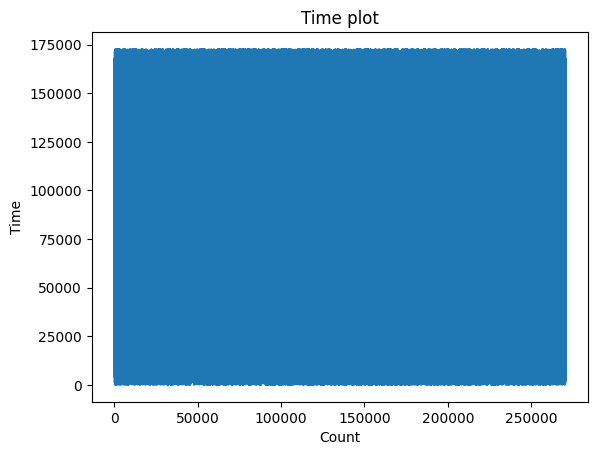

In [14]:
df = data.copy()

df['Time'].plot(title="Time plot", xlabel="Count", ylabel="Time")

<Axes: title={'center': 'Amount Boxplot'}, ylabel='Values'>

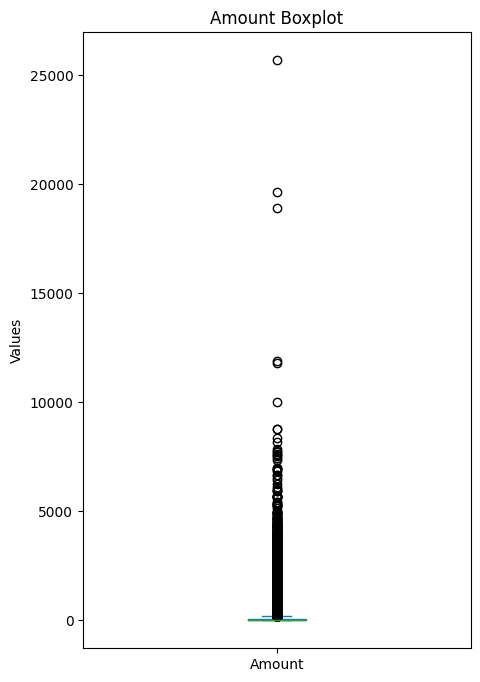

In [15]:
df['Amount'].plot(kind='box', title="Amount Boxplot", ylabel="Values", figsize=(5,8))

/var/folders/0j/9kgwgy2n3yld2hdt796pyp3w0000gn/T/ipykernel_69732/3610081977.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Class", palette=["blue","red"])


Text(0.5, 1.0, 'Non-Fraud (0) vs Fraud (1)')

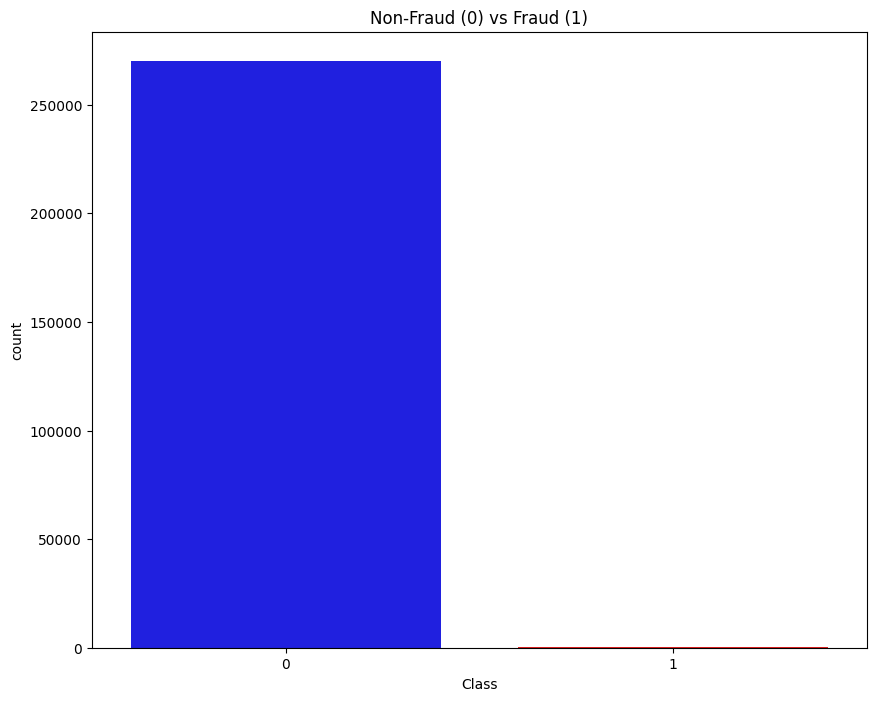

In [16]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x="Class", palette=["blue","red"])
plt.title("Non-Fraud (0) vs Fraud (1)")

<Axes: title={'center': 'Density Distribution for Amount'}, xlabel='Amount', ylabel='Density'>

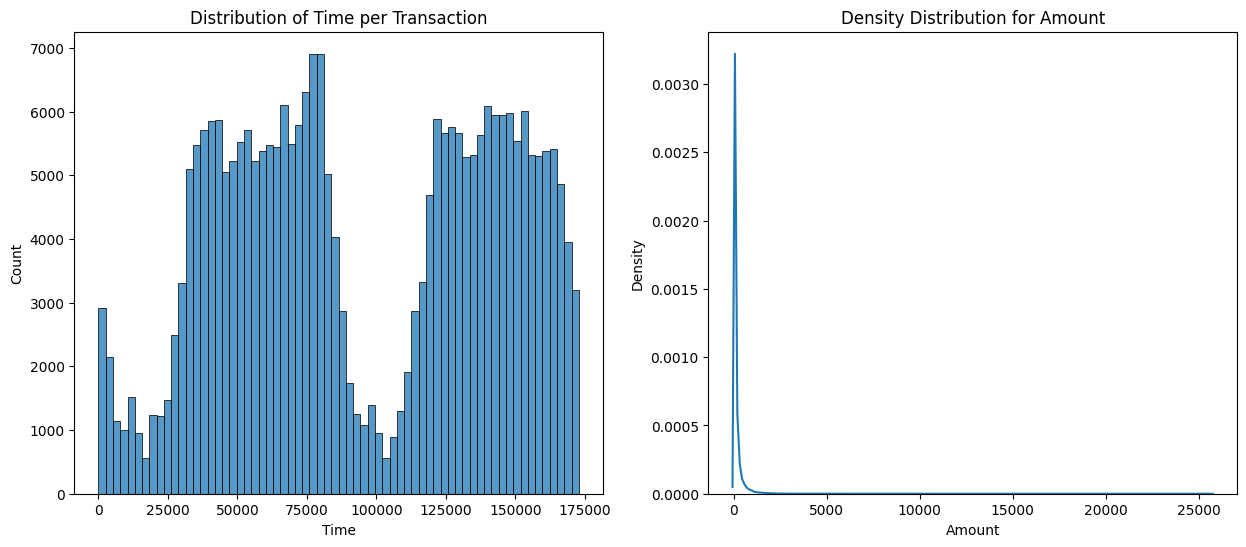

In [17]:
# Distribution plots of Time and Amount 
fig = plt.figure(figsize=(15,6))

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

ax0.set_title("Distribution of Time per Transaction")

ax1.set_xlabel("Amount")
ax1.set_title("Density Distribution for Amount")

sns.histplot(data=df["Time"], ax=ax0, )
sns.kdeplot(data=df["Amount"].values, ax=ax1)

In [18]:
df["Time"].values.reshape(-1,1)

array([[ 84558.],
       [ 43575.],
       [142280.],
       ...,
       [  2937.],
       [147710.],
       [ 60764.]], shape=(270566, 1))

In [19]:
# Data scaling and balancing. 

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

time_array = df["Time"].values.reshape(-1,1)
amount_array = df["Amount"].values.reshape(-1,1)

df["Time_scaled"],df["Amount_scaled"] = scaler.fit_transform(time_array), scaler.fit_transform(amount_array)

In [20]:
df.shape

(270566, 33)

In [21]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_scaled', 'Amount_scaled'],
      dtype='object')

In [22]:
df.drop(columns=["Time", "Amount"], axis=1, inplace=True)

In [23]:
df["Class"].value_counts()

Class
0    270099
1       467
Name: count, dtype: int64

In [24]:
# Splitting the data

X_1 = df.copy()
y_1 = X_1.pop("Class")

In [25]:
y_1.sum()

np.int64(467)

In [26]:
X_1.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_scaled,Amount_scaled
0,1.225896,-0.559735,0.748132,-0.899091,-1.176249,-0.359097,-0.824614,0.254095,1.901373,-0.849036,...,-0.006633,0.093979,-0.064239,-0.035617,0.443813,-0.676337,0.075715,0.017241,-0.001580,-0.293255
1,-0.316250,0.973117,0.819911,-0.212413,0.603125,0.038185,0.542425,0.192143,-0.163004,-0.522900,...,-0.314296,-0.850765,-0.093547,-1.015952,-0.135989,0.167666,0.253151,0.082388,-0.483022,-0.244519
2,2.113127,-0.025811,-1.341639,0.248042,0.242917,-0.805679,0.206122,-0.321813,0.505600,0.058555,...,-0.328919,-0.780767,0.248977,-0.639701,-0.187189,0.237040,-0.067867,-0.065920,0.676501,-0.294791
3,1.222559,0.262690,0.115831,0.566754,-0.026937,-0.396594,0.005081,-0.038370,0.068277,-0.327019,...,-0.279870,-0.794678,0.108408,-0.328816,0.184750,0.145903,-0.009294,0.024966,-0.344873,-0.167714
4,-5.263760,-6.321337,0.071344,0.149963,3.436535,-4.037193,-2.685129,0.671619,-1.287235,0.279237,...,0.991033,0.468536,0.079092,0.636338,-0.279928,-0.429728,0.352316,-0.810679,-0.572443,1.200950


In [27]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_1, y_1)

In [28]:
X_resampled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_scaled,Amount_scaled
0,1.225896,-0.559735,0.748132,-0.899091,-1.176249,-0.359097,-0.824614,0.254095,1.901373,-0.849036,...,-0.006633,0.093979,-0.064239,-0.035617,0.443813,-0.676337,0.075715,0.017241,-0.001580,-0.293255
1,-0.316250,0.973117,0.819911,-0.212413,0.603125,0.038185,0.542425,0.192143,-0.163004,-0.522900,...,-0.314296,-0.850765,-0.093547,-1.015952,-0.135989,0.167666,0.253151,0.082388,-0.483022,-0.244519
2,2.113127,-0.025811,-1.341639,0.248042,0.242917,-0.805679,0.206122,-0.321813,0.505600,0.058555,...,-0.328919,-0.780767,0.248977,-0.639701,-0.187189,0.237040,-0.067867,-0.065920,0.676501,-0.294791
3,1.222559,0.262690,0.115831,0.566754,-0.026937,-0.396594,0.005081,-0.038370,0.068277,-0.327019,...,-0.279870,-0.794678,0.108408,-0.328816,0.184750,0.145903,-0.009294,0.024966,-0.344873,-0.167714
4,-5.263760,-6.321337,0.071344,0.149963,3.436535,-4.037193,-2.685129,0.671619,-1.287235,0.279237,...,0.991033,0.468536,0.079092,0.636338,-0.279928,-0.429728,0.352316,-0.810679,-0.572443,1.200950


In [29]:
df_balanced = pd.concat([X_resampled, y_resampled], axis=1)
df_resampled = df_balanced.sample(frac=1, random_state=42)
df_resampled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Time_scaled,Amount_scaled,Class
279710,-5.964041,4.591391,-9.455380,6.578624,-6.140660,-3.662477,-10.912945,3.733115,-5.864170,-12.986669,...,-0.168853,0.049445,0.384672,-0.077147,0.564960,1.779553,0.367227,-0.511339,-0.228862,1
397622,-0.924573,1.668864,-1.520765,1.497987,-0.618156,-1.400165,-1.885705,0.655979,-1.564742,-3.701037,...,0.022993,-0.270093,-0.100638,0.445934,-0.417665,0.573560,0.295204,-0.416235,-0.275937,1
525700,-6.040794,4.439067,-8.503348,8.283401,-6.264531,-2.805848,-11.176097,3.847139,-6.307700,-11.465923,...,0.564792,-0.398514,0.560192,-0.475489,0.267114,1.945100,0.431975,-0.511401,0.538868,1
106897,1.937001,-0.592934,0.009410,0.466233,-0.840552,0.002724,-1.072025,0.100197,2.828370,-0.376941,...,-0.114312,0.339931,0.598835,-0.634997,0.414546,-0.056761,-0.035481,0.148868,0.237397,0
536751,-5.088582,5.219017,-6.286259,5.323667,-4.754390,-1.543218,-7.087751,3.659557,-4.796711,-7.511015,...,-0.331888,-0.054614,-0.101151,-0.113312,-0.082346,0.371647,0.321141,-0.571083,0.709403,1


<Axes: >

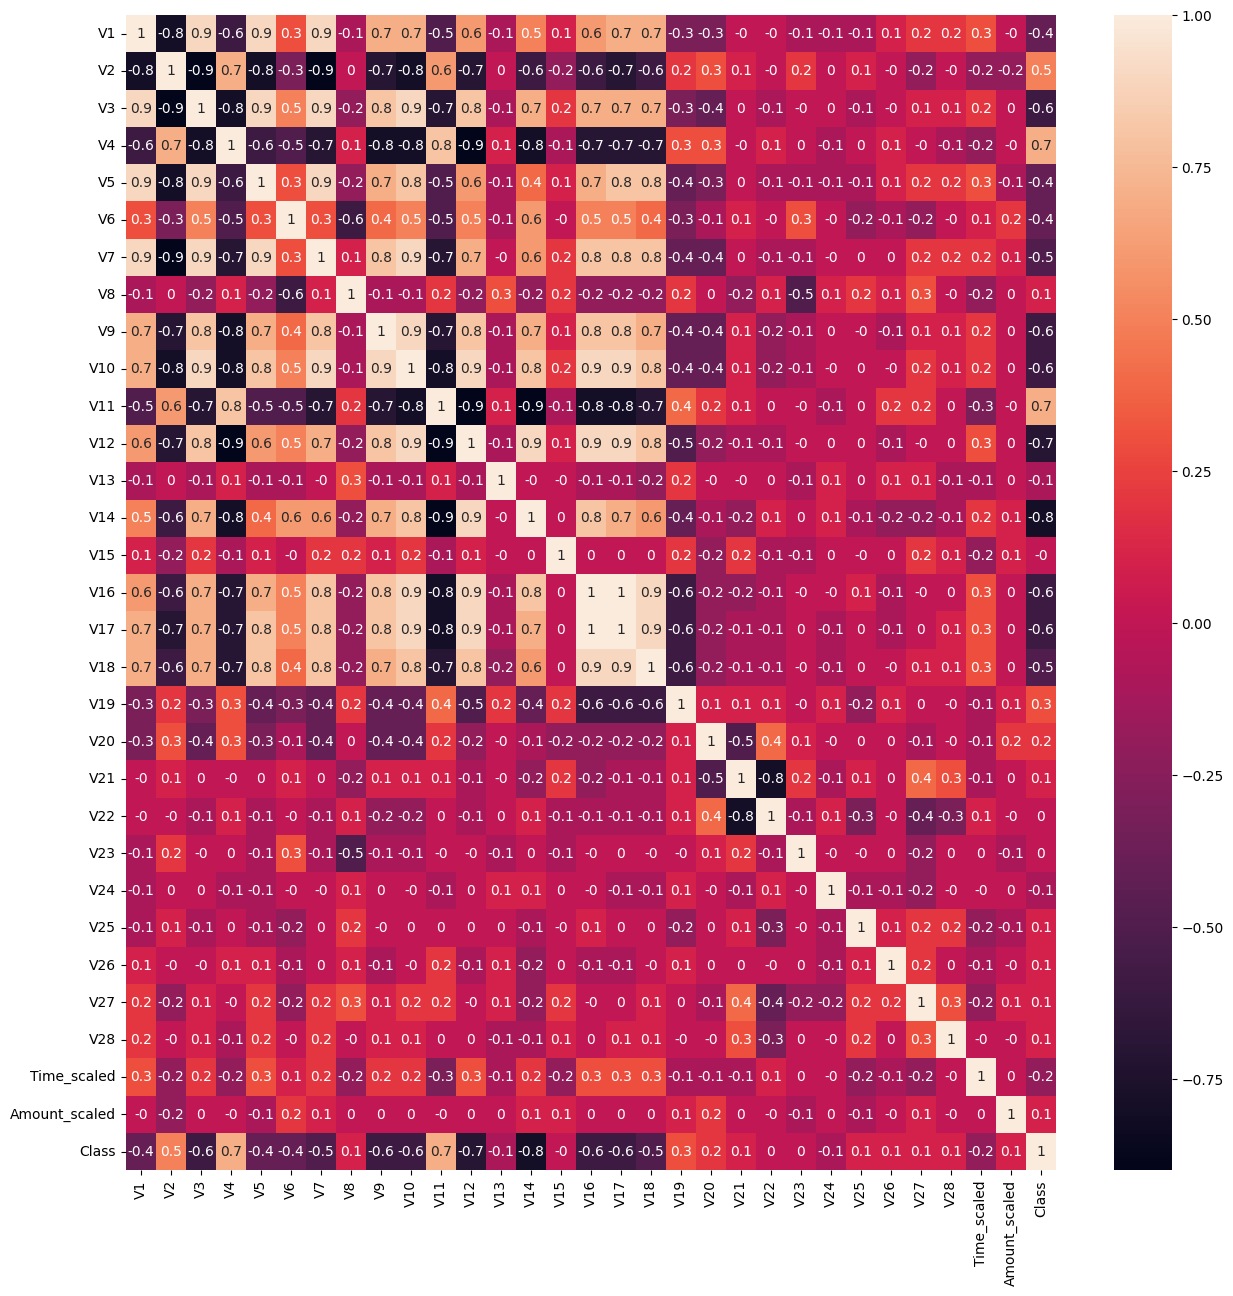

In [30]:
plt.figure(figsize=(15, 15))
sns.heatmap(round(df_resampled.corr(),1), annot=True)

In [31]:
df_balanced.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Time_scaled',
       'Amount_scaled', 'Class'],
      dtype='object')

In [32]:
df_attributes = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
                'V12', 'V13', 'V14' 
                ]
for parameter in df_attributes:
    pearson_coef, p_value = stats.pearsonr(df_resampled[parameter], df_resampled['Class'])
    print(parameter)
    print('The Pearson Correlation Coefficient for ', parameter, ' is ', pearson_coef, 'with a P-value of P =', p_value)

V1
The Pearson Correlation Coefficient for  V1  is  -0.4260635870977437 with a P-value of P = 0.0
V2
The Pearson Correlation Coefficient for  V2  is  0.4998646946518632 with a P-value of P = 0.0
V3
The Pearson Correlation Coefficient for  V3  is  -0.562688757644174 with a P-value of P = 0.0
V4
The Pearson Correlation Coefficient for  V4  is  0.7150287314939588 with a P-value of P = 0.0
V5
The Pearson Correlation Coefficient for  V5  is  -0.38605888779557257 with a P-value of P = 0.0
V6
The Pearson Correlation Coefficient for  V6  is  -0.4164696923421548 with a P-value of P = 0.0
V7
The Pearson Correlation Coefficient for  V7  is  -0.4782082008736075 with a P-value of P = 0.0
V8
The Pearson Correlation Coefficient for  V8  is  0.07381397839252954 with a P-value of P = 0.0
V9
The Pearson Correlation Coefficient for  V9  is  -0.5804410320076577 with a P-value of P = 0.0
V10
The Pearson Correlation Coefficient for  V10  is  -0.6365835803933018 with a P-value of P = 0.0
V11
The Pearson Corr

In [33]:
df_attributes = ['V15','V16', 'V17', 'V18', 'V19', 'V20', 'V21',
                'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
for parameter in df_attributes:
    pearson_coef, p_value = stats.pearsonr(df_resampled[parameter], df_resampled['Class'])
    print(parameter)
    print('The Pearson Correlation Coefficient for ', parameter, ' is ', pearson_coef, 'with a P-value of P =', p_value)

V15
The Pearson Correlation Coefficient for  V15  is  -0.026124019987990382 with a P-value of P = 3.432696090594957e-82
V16
The Pearson Correlation Coefficient for  V16  is  -0.6008911909222814 with a P-value of P = 0.0
V17
The Pearson Correlation Coefficient for  V17  is  -0.5681976963413283 with a P-value of P = 0.0
V18
The Pearson Correlation Coefficient for  V18  is  -0.47380525412018293 with a P-value of P = 0.0
V19
The Pearson Correlation Coefficient for  V19  is  0.2766859394893727 with a P-value of P = 0.0
V20
The Pearson Correlation Coefficient for  V20  is  0.1913527027027649 with a P-value of P = 0.0
V21
The Pearson Correlation Coefficient for  V21  is  0.13548940832614723 with a P-value of P = 0.0
V22
The Pearson Correlation Coefficient for  V22  is  0.00022668114534745663 with a P-value of P = 0.8676799977234804
V23
The Pearson Correlation Coefficient for  V23  is  0.0010995951303641503 with a P-value of P = 0.41898662509177376
V24
The Pearson Correlation Coefficient for  

In [34]:
df_attributes = ['Time_scaled', 'Amount_scaled']
for parameter in df_attributes:
    pearson_coef, p_value = stats.pearsonr(df_resampled[parameter], df_resampled['Class'])
    print(parameter)
    print('The Pearson Correlation Coefficient for ', parameter, ' is ', pearson_coef, 'with a P-value of P =', p_value)

Time_scaled
The Pearson Correlation Coefficient for  Time_scaled  is  -0.17006335071924425 with a P-value of P = 0.0
Amount_scaled
The Pearson Correlation Coefficient for  Amount_scaled  is  0.05204057010436827 with a P-value of P = 1.6146e-320


### Observations

* P-Value of the following features indicate that there might not be due random chance but the correlation coefficient indicates features having virtually 0 correlation with the target variable. 
* V8
* V15
* V22
* V23
* V25

<Axes: xlabel='V10', ylabel='V7'>

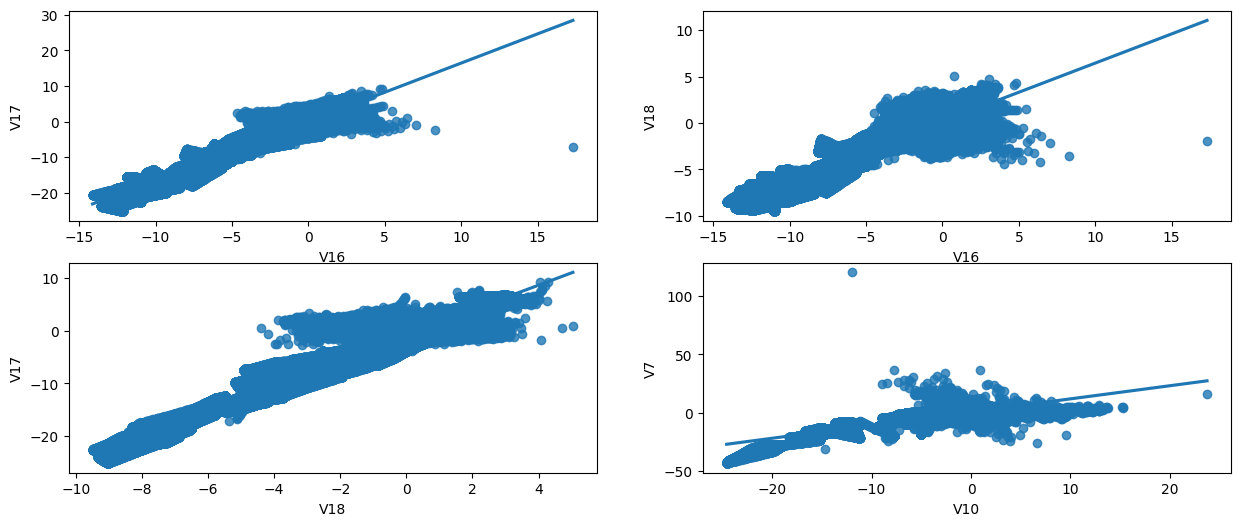

In [35]:
fig = plt.figure(figsize=(15,6))

ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

sns.regplot(df_resampled, x="V16", y="V17", ax=ax0)
sns.regplot(df_resampled, x="V16", y="V18", ax=ax1)
sns.regplot(df_resampled, x="V18", y="V17", ax=ax2)
sns.regplot(df_resampled, x="V10", y="V7", ax=ax3)


In [36]:
def calculate_vif(df):
    # Only include numeric columns
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Compute VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_numeric.columns
    vif_data["VIF"] = [
        variance_inflation_factor(df_numeric.values, i) for i in range(df_numeric.shape[1])
    ]
    return vif_data

In [37]:
vif = calculate_vif(df_resampled)
len(vif[vif["VIF"] < 10])

18

In [38]:
X = df_resampled.copy()
y = X.pop("Class")

model = RandomForestClassifier(random_state=42)
model.fit(X, y)

importances = model.feature_importances_
important_features = [feature for feature, importance in zip(X.columns, importances) if importance > 0.01]

In [39]:
print(important_features)
print(len(important_features))

['V1', 'V2', 'V3', 'V4', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V21', 'V27', 'Amount_scaled']
16


In [40]:
print(importances)
print(len(importances))

[0.01005365 0.02597335 0.05608973 0.10787639 0.00777066 0.00765612
 0.02507263 0.01415084 0.0147823  0.11394923 0.07654309 0.07948653
 0.00740704 0.20983137 0.00602447 0.04681622 0.0886441  0.00882034
 0.00852816 0.00775148 0.0122233  0.00538352 0.00670298 0.00472904
 0.00535033 0.00647818 0.01118843 0.00599211 0.00740058 0.01132382]
30


In [41]:
mi_scores = mutual_info_classif(X, y)
mi_features = pd.Series(mi_scores, index=pd.DataFrame(X).columns)
selected_features = mi_features[mi_features > 0.01].index  # Keep significant features
X_mi = pd.DataFrame(X)[selected_features]
X_mi

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_scaled,Amount_scaled
279710,-5.964041,4.591391,-9.455380,6.578624,-6.140660,-3.662477,-10.912945,3.733115,-5.864170,-12.986669,...,2.016498,-0.168853,0.049445,0.384672,-0.077147,0.564960,1.779553,0.367227,-0.511339,-0.228862
397622,-0.924573,1.668864,-1.520765,1.497987,-0.618156,-1.400165,-1.885705,0.655979,-1.564742,-3.701037,...,0.539022,0.022993,-0.270093,-0.100638,0.445934,-0.417665,0.573560,0.295204,-0.416235,-0.275937
525700,-6.040794,4.439067,-8.503348,8.283401,-6.264531,-2.805848,-11.176097,3.847139,-6.307700,-11.465923,...,2.267546,0.564792,-0.398514,0.560192,-0.475489,0.267114,1.945100,0.431975,-0.511401,0.538868
106897,1.937001,-0.592934,0.009410,0.466233,-0.840552,0.002724,-1.072025,0.100197,2.828370,-0.376941,...,-0.125019,-0.114312,0.339931,0.598835,-0.634997,0.414546,-0.056761,-0.035481,0.148868,0.237397
536751,-5.088582,5.219017,-6.286259,5.323667,-4.754390,-1.543218,-7.087751,3.659557,-4.796711,-7.511015,...,1.297390,-0.331888,-0.054614,-0.101151,-0.113312,-0.082346,0.371647,0.321141,-0.571083,0.709403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,-1.872777,0.133574,2.876072,1.664079,0.561267,2.865288,-0.492029,1.090813,0.285594,-0.131055,...,-0.105983,0.028538,-0.044835,-1.051158,0.019258,-0.058160,-0.271386,0.168467,-0.522446,0.091049
259178,1.672679,-0.900513,-0.996363,-0.148959,0.369404,1.714045,-0.624563,0.589491,1.142088,-0.279517,...,-0.248406,-0.719583,0.430702,-0.779147,-0.731662,-0.353551,0.023646,-0.042559,0.705059,1.154308
365838,-1.968790,-0.435045,-3.158692,4.075848,-3.857480,0.737247,0.908677,0.657821,-2.353433,-3.385314,...,1.164862,0.639108,1.959493,0.150058,0.538646,0.143860,0.077099,0.129219,0.248808,12.310320
131932,-0.521527,0.599811,0.327331,-1.174201,2.761340,3.484369,0.315962,0.694014,-0.226778,-0.292226,...,-0.051623,-0.233543,-0.163424,0.962325,-0.119230,-0.726358,-0.161645,-0.065175,-0.235411,-0.167574


In [42]:
from sklearn.feature_selection import VarianceThreshold

X_vt = VarianceThreshold(threshold=0.01).fit_transform(X)
X_vt

array([[-5.9640407 ,  4.59139112, -9.45537971, ...,  0.36722661,
        -0.51133916, -0.22886199],
       [-0.92457338,  1.66886412, -1.52076547, ...,  0.2952045 ,
        -0.41623491, -0.27593656],
       [-6.040794  ,  4.43906711, -8.50334751, ...,  0.43197499,
        -0.51140106,  0.53886793],
       ...,
       [-1.9687898 , -0.43504522, -3.15869166, ...,  0.12921886,
         0.24880787, 12.31032022],
       [-0.52152736,  0.59981118,  0.3273309 , ..., -0.065175  ,
        -0.23541125, -0.16757436],
       [-0.59480901,  1.21119823, -0.62745361, ...,  0.20318169,
         0.4334835 , -0.28627287]], shape=(540198, 30))

In [43]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

classifiers = {
    "LogisticRegression":LogisticRegression(),
    "RandomForestClassifier":RandomForestClassifier()
}

for key,classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    train_score = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=5)
    print(f"Classifier: {classifier} training score: {train_score.mean()}.")


Classifier: LogisticRegression() training score: 0.9499280348176373.
Classifier: RandomForestClassifier() training score: 0.9998796735522072.


In [45]:
logreg_params ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs'],
             'max_iter': [1000]}

logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg,logreg_params, cv=5)
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'max_iter': [1000],
                         'penalty': ['l2'], 'solver': ['lbfgs']})

In [46]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.9499280348176373


In [47]:
logreg_yhat = logreg_cv.predict(X_test)
logreg_cm = confusion_matrix(y_true=y_test, y_pred=logreg_yhat)
logreg_cm

array([[52504,  1309],
       [ 4180, 50047]])

In [48]:
print(classification_report(y_test, logreg_yhat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     53813
           1       0.97      0.92      0.95     54227

    accuracy                           0.95    108040
   macro avg       0.95      0.95      0.95    108040
weighted avg       0.95      0.95      0.95    108040



In [49]:
# rf_params = {'criterion': ['gini', 'entropy','log_loss'],
#      'max_depth': [2*n for n in range(1,10)],
#      'max_features': ['log2', 'sqrt'],
#      'min_samples_leaf': [1, 2, 4],
#      'min_samples_split': [2, 5, 10]}

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [50]:
model_yhat = model_rf.predict(X_test)
model_cm = confusion_matrix(y_test, model_yhat)
model_cm

array([[53808,     5],
       [    0, 54227]])

In [51]:
print(classification_report(y_test, model_yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     53813
           1       1.00      1.00      1.00     54227

    accuracy                           1.00    108040
   macro avg       1.00      1.00      1.00    108040
weighted avg       1.00      1.00      1.00    108040



In [52]:
logreg_proba = logreg_cv.predict_proba(X_test)[:, 1]
rf_model_proba = model_rf.predict_proba(X_test)[:, 1]

fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_proba)
fpr_rf_model, tpr_rf_model, thresholds_rf_model = roc_curve(y_test, rf_model_proba)

roc_auc_logreg = roc_auc_score(y_test, logreg_proba)
roc_auc_rf_model = roc_auc_score(y_test, rf_model_proba)
print(f"Logistic Regression ROC-AUC score: {roc_auc_logreg:2f}")
print(f"Random Forest ROC-AUC score: {roc_auc_rf_model:2f}")

Logistic Regression ROC-AUC score: 0.990184
Random Forest ROC-AUC score: 1.000000


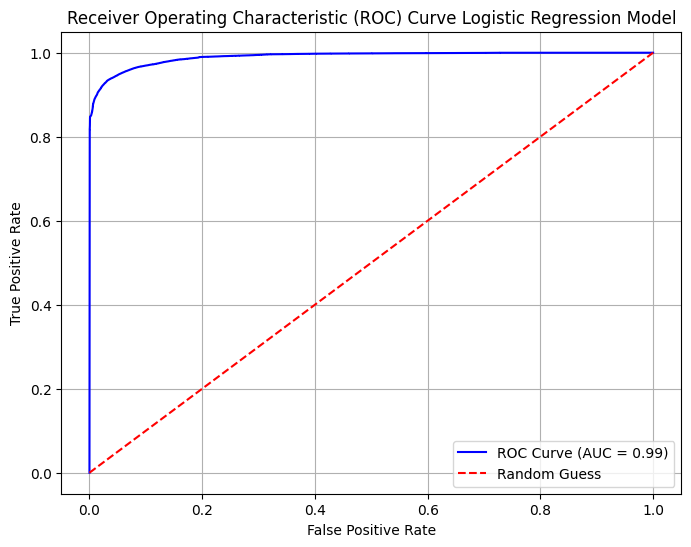

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f"ROC Curve (AUC = {roc_auc_logreg:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve Logistic Regression Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

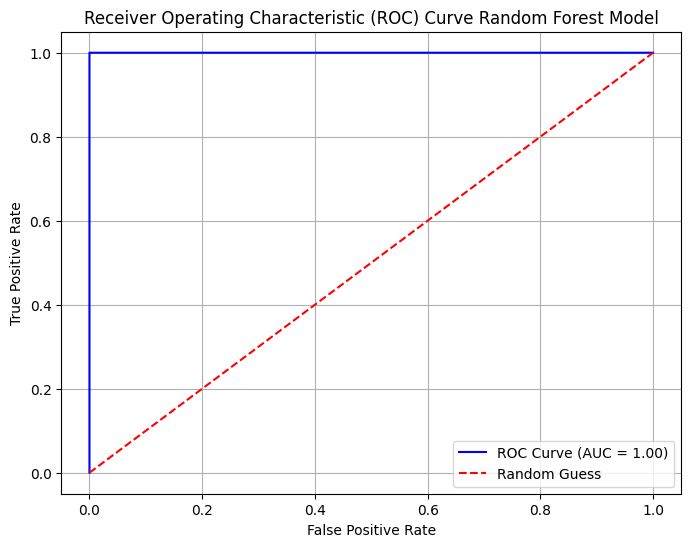

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_model, tpr_rf_model, color='blue', label=f"ROC Curve (AUC = {roc_auc_rf_model:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve Random Forest Model")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [55]:
# test_df = pd.DataFrame(y_test)
# test_df['u_id'] = [uuid.uuid4() for i in range(len(test_df.index))]